In [8]:
pip install huggingface_hub ultralytics torchvision opencv-python

Note: you may need to restart the kernel to use updated packages.


In [9]:
!pip install fastapi uvicorn python-multipart aiofiles nest_asyncio pyngrok


In [1]:
!curl https://project.inria.fr/aerialimagelabeling/files/2011/12/vie1.jpg > image.jpg

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  281k  100  281k    0     0   143k      0  0:00:01  0:00:01 --:--:--  143k


In [3]:
from huggingface_hub import hf_hub_download
from transformers import SegformerForSemanticSegmentation, SegformerFeatureExtractor
from ultralytics import YOLO
import torch, cv2, numpy as np
from PIL import Image
import os

# ================================
# 🔧 CONFIGURACIÓN
# ================================
SEGFORMER_REPO = "JGuevara-12/segformer-roofdefects"
SEGFORMER_FILENAME = "model.pt"

YOLO_REPO = "JGuevara-12/yolo-roof-damage"
YOLO_FILENAME = "yolov8/weights/best.pt"
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
TILE_SIZE = 512

import torch
import torchvision.transforms as T
import numpy as np
import cv2
from PIL import Image
from ultralytics import YOLO
from huggingface_hub import hf_hub_download

# ---------------- DESCARGA DE MODELOS ----------------
print("📥 Descargando modelos desde Hugging Face...")
segformer_model_path = hf_hub_download(repo_id=SEGFORMER_REPO, filename=SEGFORMER_FILENAME)
yolo_model_path = hf_hub_download(repo_id=YOLO_REPO, filename=YOLO_FILENAME)



E0000 00:00:1753166794.341865     660 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1753166794.348825     660 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


📥 Descargando modelos desde Hugging Face...


In [4]:
IMAGE_PATH = "image.jpg"  # Ruta de imagen de entrada

import torch
import torchvision.transforms as T
import numpy as np
import cv2
from PIL import Image
from ultralytics import YOLO
from huggingface_hub import hf_hub_download

# ---------------- FUNCIONES ----------------
def tile_image(img, tile_size):
    h, w, _ = img.shape
    tiles, coords = [], []
    for y in range(0, h, tile_size):
        for x in range(0, w, tile_size):
            tile = img[y:y+tile_size, x:x+tile_size]
            padded_tile = np.zeros((tile_size, tile_size, 3), dtype=np.uint8)
            padded_tile[:tile.shape[0], :tile.shape[1]] = tile
            tiles.append(padded_tile)
            coords.append((x, y, tile.shape[1], tile.shape[0]))
    return tiles, coords, (h, w)

def merge_masks(masks, coords, out_shape):
    full_mask = np.zeros(out_shape, dtype=np.uint8)
    for mask, (x, y, w, h) in zip(masks, coords):
        resized_mask = cv2.resize(mask, (w, h), interpolation=cv2.INTER_NEAREST)
        full_mask[y:y+h, x:x+w] = resized_mask
    return full_mask

# ---------------- CARGA DE MODELOS ----------------
print("⚙️ Cargando modelos...")

# ✅ Carga del modelo SegFormer como TorchScript
segformer_model = torch.jit.load(segformer_model_path, map_location=DEVICE)
segformer_model.eval()

# ✅ Carga del modelo YOLOv8
yolo_model = YOLO(yolo_model_path)


⚙️ Cargando modelos...


In [16]:
import os, cv2, numpy as np
import pandas as pd
from PIL import Image as PILImage, ImageDraw
from torchvision import transforms as T

def process_image(image_path, model_segformer, model_yolo, tile_size=512, device="cuda"):
    print(f"📥 Procesando {image_path}")
    img = cv2.imread(image_path)
    if img is None:
        raise FileNotFoundError(f"No se pudo leer la imagen: {image_path}")
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # === Tileado ===
    tiles, coords, full_shape = tile_image(img_rgb, tile_size)

    # === Segmentación por tiles ===
    masks = []
    transform = T.Compose([
        T.ToTensor(),
        T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    for tile in tiles:
        tensor = transform(PILImage.fromarray(tile)).unsqueeze(0).to(device)
        with torch.inference_mode():
            logits = model_segformer(tensor)
            pred = logits.argmax(dim=1).squeeze().cpu().numpy().astype(np.uint8)
        masks.append(pred)
    roof_mask = merge_masks(masks, coords, (full_shape[0], full_shape[1]))

    # === Detección completa con YOLOv8 ===
    results = model_yolo.predict(img_rgb, conf=0.5)
    boxes = results[0].boxes

    # === Filtro: solo boxes que estén sobre techos ===
    filtered_boxes = []
    for box in boxes:
        x1, y1, x2, y2 = map(int, box.xyxy[0])
        cx, cy = int((x1 + x2)/2), int((y1 + y2)/2)
        if 0 <= cy < roof_mask.shape[0] and 0 <= cx < roof_mask.shape[1]:
            if roof_mask[cy, cx] == 1:
                filtered_boxes.append([x1, y1, x2, y2, float(box.conf[0])])

    # === Guardado de outputs ===
    base_name = os.path.splitext(os.path.basename(image_path))[0]
    out_pred_path = f"{base_name}_yolo_preds.jpg"
    out_masked_path = f"{base_name}_masked.png"
    out_mask_path = f"{base_name}_full_mask.png"
    out_metrics_path = f"{base_name}_metrics.csv"

    # Imagen combinada (detección sobre original)
    img_draw = img_rgb.copy()
    green_overlay = np.zeros_like(img_draw)
    green_overlay[roof_mask == 1] = [0, 255, 0]
    img_draw = cv2.addWeighted(img_draw, 1.0, green_overlay, 0.4, 0)

    for box in filtered_boxes:
        x1, y1, x2, y2, conf = box
        label = f"Damage {conf:.2f}"
        cv2.rectangle(img_draw, (int(x1), int(y1)), (int(x2), int(y2)), (255, 0, 0), 2)
        cv2.putText(img_draw, label, (int(x1), int(y1) - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 1)

    cv2.imwrite(out_pred_path, cv2.cvtColor(img_draw, cv2.COLOR_RGB2BGR))
    cv2.imwrite(out_mask_path, roof_mask)
    masked_img = cv2.bitwise_and(img, img, mask=roof_mask)
    cv2.imwrite(out_masked_path, masked_img)

    # === Métricas ===
    roof_area_px = int((roof_mask > 0).sum())
    image_area_px = roof_mask.shape[0] * roof_mask.shape[1]
    roof_ratio = roof_area_px / image_area_px
    damage_count = len(filtered_boxes)
    damage_density = damage_count / (roof_area_px + 1e-6)

    df = pd.DataFrame([{
        "image": image_path,
        "roof_area_px": roof_area_px,
        "roof_ratio": round(roof_ratio, 4),
        "damage_count": damage_count,
        "damage_density": round(damage_density, 6)
    }])
    df.to_csv(out_metrics_path, index=False)

    return {
        "final_image": out_pred_path,
        "masked_image": out_masked_path,
        "roof_mask": out_mask_path,
        "metrics_path": out_metrics_path,
        "metrics": df
    }



In [17]:
result = process_image("image.jpg", segformer_model, yolo_model, tile_size=512, device=DEVICE)
print(result["metrics"])


📥 Procesando image.jpg

0: 512x512 (no detections), 9.4ms
Speed: 2.3ms preprocess, 9.4ms inference, 1.4ms postprocess per image at shape (1, 3, 512, 512)
       image  roof_area_px  roof_ratio  damage_count  damage_density
0  image.jpg        421926      0.4219             0             0.0


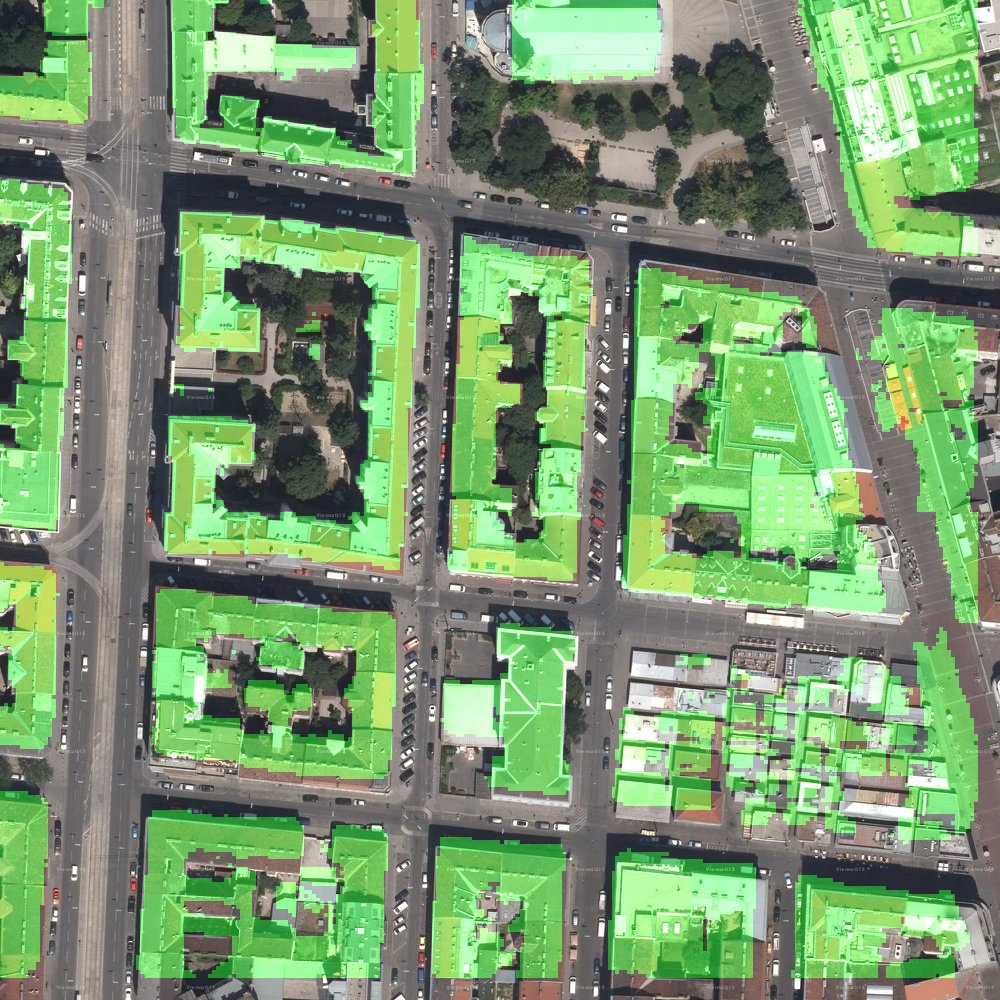

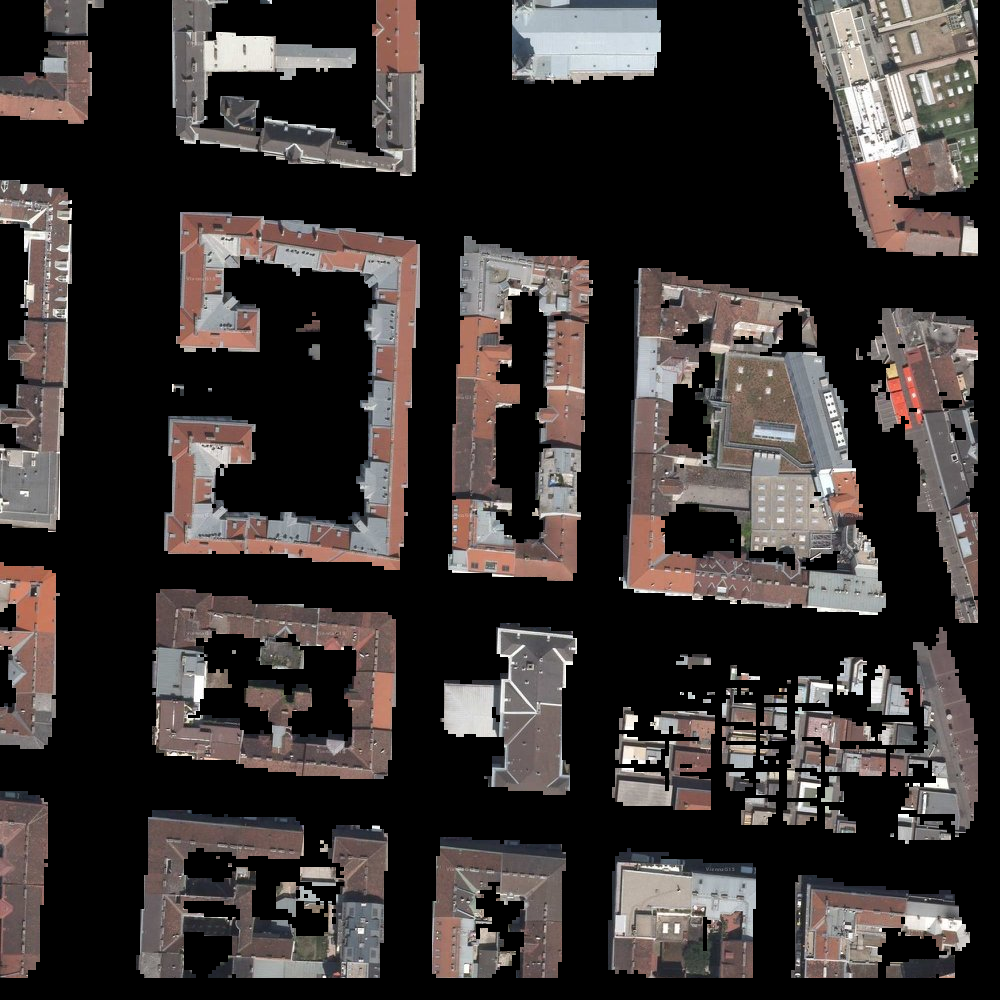

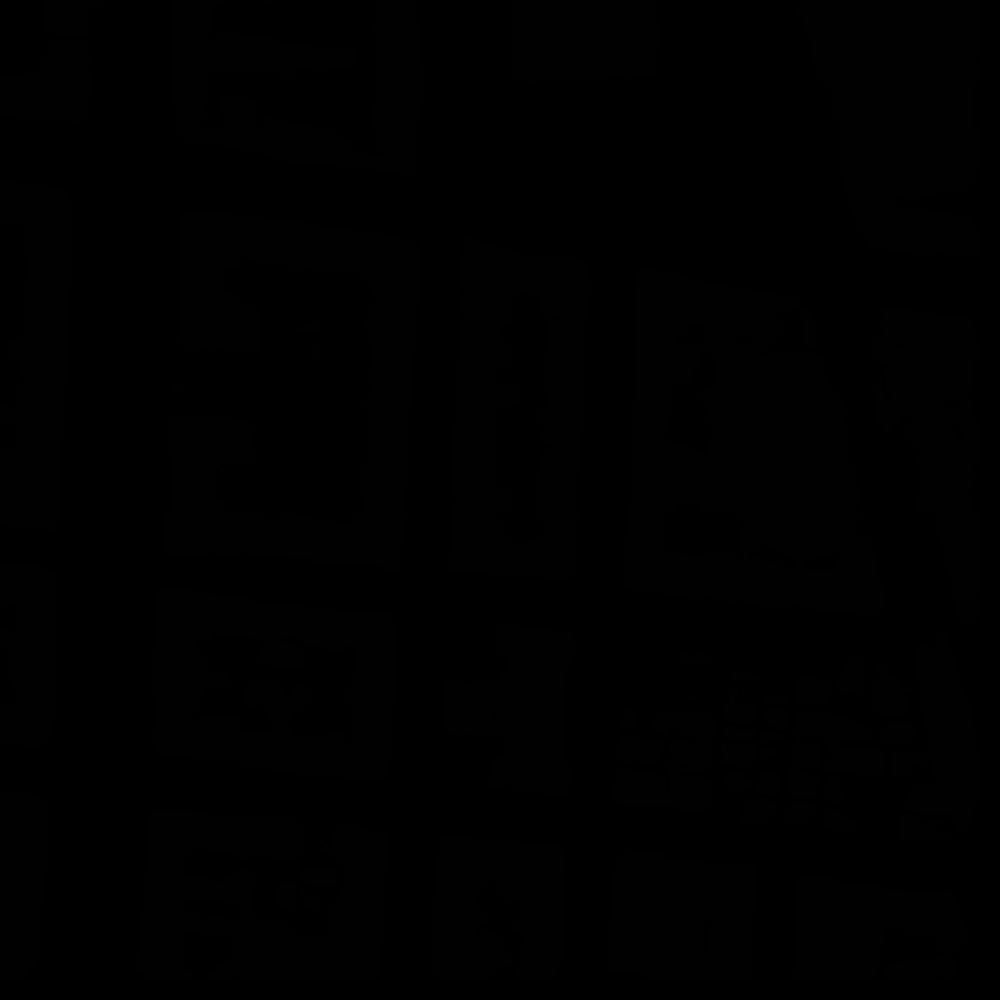

In [18]:
from IPython.display import Image, display

for path in ["image_yolo_preds.jpg", "image_masked.png", "image_full_mask.png"]:
    display(Image(filename=path))


In [19]:
# ========================================
# 📦 IMPORTACIONES Y CONFIGURACIÓN BASE
# ========================================
import os, requests, tempfile
from fastapi import FastAPI, HTTPException
from pydantic import BaseModel
from PIL import Image as PILImage
from pyngrok import ngrok
import nest_asyncio
import uvicorn
from kaggle_secrets import UserSecretsClient

# Inicializa FastAPI y aplica patch para notebooks
app = FastAPI()
nest_asyncio.apply()

# Carga el token NGROK desde Kaggle Secrets
user_secrets = UserSecretsClient()
ngrok_token = user_secrets.get_secret("NGROK")
os.environ["NGROK_AUTHTOKEN"] = ngrok_token

In [20]:
# ========================================
# 🧠 API INFERENCE ENDPOINT
# ========================================
class InferenceRequest(BaseModel):
    url: str

def upload_to_catbox(filepath):
    with open(filepath, "rb") as f:
        files = {
            "reqtype": (None, "fileupload"),
            "fileToUpload": f
        }
        r = requests.post("https://catbox.moe/user/api.php", files=files)
    if r.ok:
        return r.text.strip()
    else:
        raise Exception(f"Upload failed: {r.status_code}, {r.text}")

@app.post("/infer")
async def infer(request: InferenceRequest):
    try:
        r = requests.get(request.url)
        r.raise_for_status()
        with tempfile.NamedTemporaryFile(delete=False, suffix=".jpg") as f:
            f.write(r.content)
            local_path = f.name
    except Exception as e:
        raise HTTPException(status_code=400, detail=f"Download error: {e}")

    try:
        outputs = process_image(local_path, segformer_model, yolo_model, tile_size=512, device=DEVICE)
        results = {
            "masked_image": upload_to_catbox(outputs["masked_image"]),
            "roof_mask": upload_to_catbox(outputs["roof_mask"]),
            "detections": upload_to_catbox(outputs["final_image"]),
            "metrics_csv": upload_to_catbox(outputs["metrics_path"])
        }
        os.remove(local_path)
        return {"status": "success", "results": results}
    except Exception as e:
        raise HTTPException(status_code=500, detail=str(e))

In [21]:
@app.get("/health")
async def health_check():
    return {"status": "ok"}


In [22]:
# ========================================
# 🧪 SANITY CHECK MANUAL
# ========================================
def sanity_check(image_path="image.jpg"):
    print("🧪 Ejecutando verificación del sistema...")
    try:
        outputs = process_image(image_path, segformer_model, yolo_model, tile_size=512, device=DEVICE)
        urls = {
            "roof_mask": upload_to_catbox(outputs["roof_mask"]),
            "detections": upload_to_catbox(outputs["final_image"]),
            "metrics_csv": upload_to_catbox(outputs["metrics_path"])
        }
        print("✅ Verificación completada. Resultados disponibles:")
        for k, v in urls.items():
            print(f" - {k}: {v}")
        return urls
    except Exception as e:
        print(f"❌ Error en la verificación: {e}")
        return None

# sanity_check("image.jpg")  # Descomenta solo si quieres probar

In [12]:
# ========================================
# 🚀 LANZAR FASTAPI + NGROK + CHECK HEALTH
# ========================================
import time
from datetime import datetime
import os, requests, tempfile
from fastapi import FastAPI, HTTPException
from pydantic import BaseModel
from PIL import Image as PILImage
from pyngrok import ngrok
import nest_asyncio
import uvicorn
from kaggle_secrets import UserSecretsClient

# 🧹 Limpieza de procesos previos en puerto 8000 (solo en notebooks)
!fuser -k 8000/tcp || echo "No hay procesos colgados en el puerto 8000"

# ✅ Iniciar servidor FastAPI en background
config = uvicorn.Config(app=app, host="0.0.0.0", port=8000)
server = uvicorn.Server(config=config)

# 🧠 Ejecutar servidor en segundo plano (en notebooks)
import threading
threading.Thread(target=server.run, daemon=True).start()

# ⏳ Esperar a que arranque el servidor
print("⏳ Esperando que el servidor FastAPI se estabilice...")
time.sleep(5)

# 🔗 Iniciar túnel Ngrok
public_url = ngrok.connect(8000)
url_base = public_url.public_url
print(f"🔗 Tu API está disponible públicamente en: {url_base}/docs")

# ✅ Verificar /health y subir log si falla
log_file = "health_check_log.txt"
timestamp = datetime.now().strftime("%Y-%m-%d %H:%M:%S")

try:
    r = requests.get(f"{url_base}/health", timeout=5)
    if r.ok:
        print("✅ API activa y escuchando en /health")
    else:
        msg = f"[{timestamp}] ⚠️ API respondió pero con error: {r.status_code} - {r.text}\n"
        print(msg)
        with open(log_file, "w") as f:
            f.write(msg)
        log_url = upload_to_catbox(log_file)
        print(f"📤 Log subido a Catbox: {log_url}")
except Exception as e:
    msg = f"[{timestamp}] ❌ Error al verificar el endpoint /health: {e}\n"
    print(msg)
    with open(log_file, "w") as f:
        f.write(msg)
    log_url = upload_to_catbox(log_file)
    print(f"📤 Log subido a Catbox: {log_url}")


No hay procesos colgados en el puerto 8000


INFO:     Started server process [660]
INFO:     Waiting for application startup.
INFO:     Application startup complete.
INFO:     Uvicorn running on http://0.0.0.0:8000 (Press CTRL+C to quit)


⏳ Esperando que el servidor FastAPI se estabilice...
🔗 Tu API está disponible públicamente en: https://84d74dbc3b0d.ngrok-free.app/docs
INFO:     34.80.71.55:0 - "GET /health HTTP/1.1" 200 OK
✅ API activa y escuchando en /health
INFO:     2800:484:9079:99a0:d819:d78c:cca8:bc62:0 - "GET /docs HTTP/1.1" 200 OK
INFO:     2800:484:9079:99a0:d819:d78c:cca8:bc62:0 - "GET /openapi.json HTTP/1.1" 200 OK
📥 Procesando /tmp/tmpo7sxwine.jpg

0: 288x512 4 items, 47.3ms
Speed: 1.7ms preprocess, 47.3ms inference, 137.4ms postprocess per image at shape (1, 3, 288, 512)
INFO:     2800:484:9079:99a0:d819:d78c:cca8:bc62:0 - "POST /infer HTTP/1.1" 200 OK


In [23]:
from IPython.display import display, Image as IPImage
import requests
import os

# URL pública de la imagen para la prueba
test_image_url = "https://aircamdrone.co.uk/wp-content/uploads/2023/02/DJI_0001-HDR.jpg"

# URL de la API infer recién desplegada (ajusta si cambia)
api_url = f"{url_base}/infer"

# Payload para la API
payload = {"url": test_image_url}

# Realizar la inferencia
print("🚀 Enviando imagen de prueba al endpoint /infer ...")
response = requests.post(api_url, json=payload)
if response.ok:
    data = response.json()
    print("✅ Inferencia exitosa")
    print("📌 Mostrando resultados...")

    # Mostrar cada imagen resultante
    for label, img_url in data["results"].items():
        if img_url.endswith((".png", ".jpg", ".jpeg")):
            print(f"🖼️ {label}:")
            display(IPImage(url=img_url))
        elif img_url.endswith(".csv"):
            print(f"📄 CSV de métricas: {img_url}")
else:
    print("❌ Error durante la inferencia:")
    print(response.status_code, response.text)



🚀 Enviando imagen de prueba al endpoint /infer ...
📥 Procesando /tmp/tmp6q52_gn7.jpg

0: 384x512 (no detections), 8.7ms
Speed: 2.4ms preprocess, 8.7ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 512)
INFO:     34.80.71.55:0 - "POST /infer HTTP/1.1" 200 OK
✅ Inferencia exitosa
📌 Mostrando resultados...
🖼️ masked_image:


🖼️ roof_mask:


🖼️ detections:


📄 CSV de métricas: https://files.catbox.moe/evuvgt.csv
